# Finance clustering

## Yahoo Finance

https://finance.yahoo.com/

In [6]:
!pip install yfinance
!pip install tslearn
!pip install selenium


import re
import time
import datetime
import pandas as pd
import warnings
from tqdm import tqdm
from bs4 import BeautifulSoup
from selenium import webdriver
from dataclasses import dataclass

warnings.filterwarnings("ignore", category=FutureWarning)

In [7]:
import sys
sys.path.append(
    "../"
)

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import time
from tqdm.autonotebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from selenium import webdriver
import yfinance as yf

In [8]:
def get_info(ticker_obj):
    info_keys = ['shortName', 'sector', 'industry', 'country', 'market']
    info_values = []
    for key in info_keys:
        info_values.append(ticker_obj.info.get(key, None))
    return dict(zip(info_keys, info_values))

In [9]:
msft = yf.Ticker("MSFT")
msft.history()

Open        High         Low       Close  \
Date                                                                        
2024-02-02 00:00:00-05:00  403.064642  411.888321  402.815103  410.460968   
2024-02-05 00:00:00-05:00  409.143400  410.401085  403.244305  404.901245   
2024-02-06 00:00:00-05:00  405.130811  407.216949  402.166292  404.741516   
2024-02-07 00:00:00-05:00  406.687921  413.535244  406.647987  413.285706   
2024-02-08 00:00:00-05:00  413.285725  414.792947  411.768541  413.345612   
2024-02-09 00:00:00-05:00  414.483507  420.043233  414.323799  419.773712   
2024-02-12 00:00:00-05:00  419.783705  419.963365  413.984431  414.493500   
2024-02-13 00:00:00-05:00  404.192550  409.313085  402.645423  405.570007   
2024-02-14 00:00:00-05:00  408.070007  409.839996  404.570007  409.489990   
2024-02-15 00:00:00-05:00  408.140015  409.130005  404.290009  406.559998   
2024-02-16 00:00:00-05:00  407.959991  408.290009  403.440002  404.059998   
2024-02-20 00:00:00-05:00  403.239990  404.489990  398.010010  402.790009   
2024-02-21 00:00:00-05:00  400.170013  402.290009  397.220001  402.179993   
2024-02-22 00:00:00-05:00  410.190002  412.829987  408.570007  411.649994   
2024-02-23 00:00:00-05:00  415.670013  415.859985  408.970001  410.339996   
2024-02-26 00:00:00-05:00  411.459991  412.160004  407.359985  407.540009   
2024-02-27 00:00:00-05:00  407.989990  408.320007  403.850006  407.480011   
2024-02-28 00:00:00-05:00  408.179993  409.299988  405.320007  407.720001   
2024-02-29 00:00:00-05:00  408.640015  414.200012  405.920013  413.640015   
2024-03-01 00:00:00-05:00  411.269989  415.869995  410.880005  415.500000   

                             Volume  Dividends  Stock Splits  
Date                                                          
2024-02-02 00:00:00-05:00  28245000       0.00           0.0  
2024-02-05 00:00:00-05:00  25352300       0.00           0.0  
2024-02-06 00:00:00-05:00  18382600       0.00           0.0  
2024-02-07 00:00:00-05:00  22340500       0.00           0.0  
2024-02-08 00:00:00-05:00  21225300       0.00           0.0  
2024-02-09 00:00:00-05:00  22032800       0.00           0.0  
2024-02-12 00:00:00-05:00  21202900       0.00           0.0  
2024-02-13 00:00:00-05:00  27824900       0.00           0.0  
2024-02-14 00:00:00-05:00  20401200       0.75           0.0  
2024-02-15 00:00:00-05:00  21825500       0.00           0.0  
2024-02-16 00:00:00-05:00  22281100       0.00           0.0  
2024-02-20 00:00:00-05:00  24307900       0.00           0.0  
2024-02-21 00:00:00-05:00  18631100       0.00           0.0  
2024-02-22 00:00:00-05:00  27009900       0.00           0.0  
2024-02-23 00:00:00-05:00  16295900       0.00           0.0  
2024-02-26 00:00:00-05:00  16193500       0.00           0.0  
2024-02-27 00:00:00-05:00  14835800       0.00           0.0  
2024-02-28 00:00:00-05:00  13183100       0.00           0.0  
2024-02-29 00:00:00-05:00  31947300       0.00           0.0  
2024-03-01 00:00:00-05:00  17800300       0.00           0.0

In [10]:
get_info(msft)

{'shortName': 'Microsoft Corporation',
 'sector': 'Technology',
 'industry': 'Software - Infrastructure',
 'country': 'United States',
 'market': None}

## In case you need all tickers

In [11]:
all_tickers = pd.read_csv(
    'https://raw.githubusercontent.com/shilewenuw/get_all_tickers/master/get_all_tickers/tickers.csv',
    header=None,
    error_bad_lines=False
)

all_tickers = all_tickers.values.reshape(-1)
print(len(all_tickers))
print(all_tickers[:4])

2762
['DDD' 'MMM' 'WBAI' 'WUBA']


## Loading interesting tickers

In [ ]:
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service

def load_with_selenium(url, options, chromedriver_path='C:/Windows/chromedriver.exe'):
    # https://chromedriver.chromium.org/downloads
    service = Service(executable_path=chromedriver_path)
    options = webdriver.ChromeOptions()
    driver = webdriver.Chrome(service=service, options=options)
#     driver = webdriver.Chrome(executable_path=chromedriver_path, options=options)
    driver.get(url)
    driver.implicitly_wait(2)
    df = pd.read_html(driver.find_element(By.TAG_NAME, "table").get_attribute('outerHTML'))[0]
    driver.close()
    return df

In [ ]:
%%time
n_group = 25

trending = load_with_selenium(f"https://finance.yahoo.com/trending-tickers?count={n_group}", options)
most_active = load_with_selenium(f"https://finance.yahoo.com/most-active?count={n_group}", options)
gainers = load_with_selenium(f"https://finance.yahoo.com/gainers?count={n_group}", options)
losers = load_with_selenium(f"https://finance.yahoo.com/losers?count={n_group}", options)

CPU times: total: 15.6 ms
Wall time: 3min 2s


In [ ]:
trending.head()

Symbol                           Name  Last Price Market Time   Change  \
0    MMM                     3M Company     95.4300  1:20PM EST -12.5900   
1   BABA  Alibaba Group Holding Limited     73.5400  1:20PM EST   4.9100   
2     VZ    Verizon Communications Inc.     41.8100  1:20PM EST   2.2300   
3    RTX                RTX Corporation     89.8900  1:20PM EST   4.8700   
4   PLUG                Plug Power Inc.      3.3313  1:20PM EST   0.4913   

  % Change   Volume Market Cap  Intraday High/Low  52 Week Range  Day Chart  
0  -11.66%  18.818M    52.708B                NaN            NaN        NaN  
1   +7.15%  40.513M    183.85B                NaN            NaN        NaN  
2   +5.63%  29.257M   175.761B                NaN            NaN        NaN  
3   +5.72%   12.09M   129.246B                NaN            NaN        NaN  
4  +17.30%   98.21M     2.017B                NaN            NaN        NaN

In [ ]:
most_active.head()

Symbol                             Name  Price (Intraday)  Change  \
0   PLUG                  Plug Power Inc.            3.3406  0.5006   
1    NIO                         NIO Inc.            6.2200  0.2400   
2   TSLA                      Tesla, Inc.          208.8300  0.0300   
3    AMD     Advanced Micro Devices, Inc.          168.7500  0.5700   
4   MARA  Marathon Digital Holdings, Inc.           16.4100 -0.2000   

    % Change   Volume Avg Vol (3 month) Market Cap  PE Ratio (TTM)  \
0  +17.6268%  98.309M           39.308M     2.019B             NaN   
1     +3.93%  90.964M           57.732M    12.927B             NaN   
2     +0.01%  74.455M          116.478M   663.854B           67.58   
3     +0.34%  53.866M           63.955M   282.422B         1406.25   
4     -1.23%  42.491M           70.487M     3.652B             NaN   

   52 Week Range  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN

In [ ]:
gainers.head()

Symbol                            Name  Price (Intraday)  Change % Change  \
0    TKO        TKO Group Holdings, Inc.             87.07    9.66  +12.48%   
1   OGCP    Empire State Realty OP, L.P.             10.20    0.00    0.00%   
2  LGFRY  Longfor Group Holdings Limited             11.32    0.92   +8.87%   
3  FWONK               Formula One Group             68.15    5.00   +7.93%   
4  OUKPF                       Metso Oyj             10.37    0.75   +7.80%   

   Volume Avg Vol (3 month) Market Cap  PE Ratio (TTM)  52 Week Range  
0  8.451M             1.26M     7.145B           19.79            NaN  
1   52732              4060     2.708B           30.91            NaN  
2   21765             25283     7.462B            1.97            NaN  
3  1.408M            1.001M     15.81B           35.50            NaN  
4   70006               169     8.989B           14.40            NaN

In [ ]:
losers.head()

Symbol                           Name  Price (Intraday)  Change % Change  \
0    MMM                     3M Company             95.56  -12.46  -11.53%   
1   LOGI    Logitech International S.A.             86.59   -9.34   -9.74%   
2    DHI              D.R. Horton, Inc.            142.52  -15.18   -9.62%   
3    DFH      Dream Finders Homes, Inc.             31.48   -2.84   -8.28%   
4   STRL  Sterling Infrastructure, Inc.             70.29   -6.32   -8.25%   

    Volume Avg Vol (3 month) Market Cap  PE Ratio (TTM)  52 Week Range  
0  18.873M            3.367M    52.779B             NaN            NaN  
1   1.939M            406847    13.576B           36.54            NaN  
2   7.032M            2.532M    47.461B           10.32            NaN  
3   185912            426744     2.931B           12.06            NaN  
4   416557            385618     2.168B           18.40            NaN

In [ ]:
# Исключим пересечения. Возьмем только уникальные тикеты
interesting_tickers = set()

for df in [trending, most_active, gainers, losers]:
    interesting_tickers = interesting_tickers.union(set(df['Symbol']))

interesting_tickers = list(interesting_tickers)
print(interesting_tickers[:4])
print(len(interesting_tickers))

['TROX', 'PWR', 'CIHKY', 'TTNDY']
90


In [12]:
interesting_tickers = all_tickers
print(interesting_tickers[:4])
print(len(interesting_tickers))

['DDD' 'MMM' 'WBAI' 'WUBA']
2762


In [14]:
load = True # False # True about 15-20 min

if load:
    full_ticker_data = []
    for ticker in tqdm(interesting_tickers):
        try:
            ticker_obj = yf.Ticker(ticker)
            close_price = ticker_obj.history(period='1mo', interval='1d')['Close'].to_dict()
            info = get_info(ticker_obj)
            info.update(close_price)
            full_ticker_data.append(info)
        except Exception as e:
            print(e)
            continue

    full_ticker_df = pd.DataFrame(full_ticker_data)
    full_ticker_df.to_csv("full_ticker_df_month_07_2021.csv")

else:
    full_ticker_df = pd.read_csv("full_ticker_df_month_07_2021.csv", index_col=0)
    datetime_columns = pd.to_datetime(full_ticker_df.columns[5:])
    full_ticker_df.columns = list(full_ticker_df.columns[:5]) + list(datetime_columns)

plt.show()

In [15]:
full_ticker_df.head()

shortName                  sector  \
0                 Farfetch Limited       Consumer Cyclical   
1                        Snap Inc.  Communication Services   
2                    Arvinas, Inc.              Healthcare   
3  COLOPLAST SPON ADS EACH REPR 0.              Healthcare   
4                      Carvana Co.       Consumer Cyclical   

                         industry         country     market  \
0                 Internet Retail  United Kingdom  us_market   
1  Internet Content & Information   United States  us_market   
2                   Biotechnology   United States  us_market   
3  Medical Instruments & Supplies         Denmark  us_market   
4                 Internet Retail   United States  us_market   

   2022-07-18 00:00:00  2022-07-19 00:00:00  2022-07-20 00:00:00  \
0                 6.73             7.760000             8.350000   
1                13.92            14.150000            15.510000   
2                47.50            51.919998            54.560001   
3                11.19            11.425000            11.205000   
4                22.25            22.850000            27.379999   

   2022-07-21 00:00:00  2022-07-22 00:00:00  ...  2022-08-05 00:00:00  \
0             8.820000             8.360000  ...                 8.94   
1            16.350000             9.960000  ...                10.18   
2            54.799999            50.320000  ...                55.43   
3            11.810000            11.850000  ...                11.34   
4            28.209999            25.379999  ...                46.98   

   2022-08-08 00:00:00  2022-08-09 00:00:00  2022-08-10 00:00:00  \
0             9.720000             8.880000             9.710000   
1            10.410000            10.160000            10.570000   
2            55.830002            55.799999            57.990002   
3            11.410000            11.380000            11.730000   
4            46.459999            41.430000            47.310001   

   2022-08-11 00:00:00  2022-08-12 00:00:00  2022-08-15 00:00:00  \
0             9.900000            10.160000             9.930000   
1            11.110000            11.620000            12.240000   
2            54.540001            54.459999            54.119999   
3            11.820000            11.600000            11.585000   
4            50.130001            52.099998            51.000000   

   2022-08-16 00:00:00  2022-08-17 00:00:00  2022-08-18 00:00:00  
0                 9.99             8.830000                  NaN  
1                12.61            12.090000                  NaN  
2                52.48            46.700001                  NaN  
3                11.34            12.170000                  NaN  
4                54.59            49.619999                  NaN  

[5 rows x 29 columns]

In [16]:
full_ticker_df.isnull().sum(axis=1)

0     1
1     1
2     1
3     1
4     1
     ..
91    1
92    1
93    1
94    1
95    1
Length: 96, dtype: int64

In [17]:
full_ticker_df = full_ticker_df.iloc[:, :-1] # Выбросим пустой столбец

In [18]:
prices = full_ticker_df.iloc[:, 5:].T

In [19]:
prices = prices.fillna(method='backfill')  #Заполним пропуски назад
prices = prices.fillna(method='ffill')     #Заполним пропуски вперед

In [20]:
full_ticker_df = full_ticker_df.iloc[:, :5].join(prices.T) #Выкинуть пропуски

In [21]:
full_ticker_df.dropna(inplace=True)

In [22]:
full_ticker_df.shape

(96, 28)

In [23]:
full_ticker_df

shortName                  sector  \
0                  Farfetch Limited       Consumer Cyclical   
1                         Snap Inc.  Communication Services   
2                     Arvinas, Inc.              Healthcare   
3   COLOPLAST SPON ADS EACH REPR 0.              Healthcare   
4                       Carvana Co.       Consumer Cyclical   
..                              ...                     ...   
91  Blueprint Medicines Corporation              Healthcare   
92      Orchid Island Capital, Inc.             Real Estate   
93                Banco Bradesco Sa      Financial Services   
94        Opendoor Technologies Inc             Real Estate   
95  TURKIYE GARANTI BANKASI AS ADS       Financial Services   

                          industry         country     market  \
0                  Internet Retail  United Kingdom  us_market   
1   Internet Content & Information   United States  us_market   
2                    Biotechnology   United States  us_market   
3   Medical Instruments & Supplies         Denmark  us_market   
4                  Internet Retail   United States  us_market   
..                             ...             ...        ...   
91                   Biotechnology   United States  us_market   
92                   REIT—Mortgage   United States  us_market   
93                  Banks—Regional          Brazil  us_market   
94            Real Estate Services   United States  us_market   
95                  Banks—Regional          Turkey  us_market   

    2022-07-18 00:00:00  2022-07-19 00:00:00  2022-07-20 00:00:00  \
0              6.730000             7.760000             8.350000   
1             13.920000            14.150000            15.510000   
2             47.500000            51.919998            54.560001   
3             11.190000            11.425000            11.205000   
4             22.250000            22.850000            27.379999   
..                  ...                  ...                  ...   
91            52.459999            55.520000            55.150002   
92             2.839500             2.918375             2.967672   
93             2.510000             2.620000             2.550000   
94             5.030000             5.530000             5.660000   
95             0.780000             0.790000             0.790000   

    2022-07-21 00:00:00  2022-07-22 00:00:00  ...  2022-08-04 00:00:00  \
0              8.820000             8.360000  ...             9.030000   
1             16.350000             9.960000  ...            10.250000   
2             54.799999            50.320000  ...            51.410000   
3             11.810000            11.850000  ...            11.900000   
4             28.209999            25.379999  ...            33.540001   
..                  ...                  ...  ...                  ...   
91            55.240002            51.880001  ...            64.720001   
92             3.036687             3.026828  ...             3.170000   
93             2.550000             2.550000  ...             2.870000   
94             5.610000             5.170000  ...             4.700000   
95             0.840000             0.840000  ...             0.820000   

    2022-08-05 00:00:00  2022-08-08 00:00:00  2022-08-09 00:00:00  \
0              8.940000             9.720000             8.880000   
1             10.180000            10.410000            10.160000   
2             55.430000            55.830002            55.799999   
3             11.340000            11.410000            11.380000   
4             46.980000            46.459999            41.430000   
..                  ...                  ...                  ...   
91            68.139999            71.089996            68.169998   
92             3.160000             3.170000             3.160000   
93             2.950000             2.970000             3.000000   
94             5.720000             5.890000             5.430000   
95         

# Время провернуть кластерный анализ по финансовом рынке

In [ ]:
full_ticker_df.sample(15)

shortName              sector  \
43                       D/S Norden         Industrials   
46          Crescent Energy Company              Energy   
55       Palantir Technologies Inc.          Technology   
53   Ginkgo Bioworks Holdings, Inc.          Healthcare   
41       Applied DNA Sciences, Inc.          Healthcare   
65           CHINA EVERGRANDE GROUP         Real Estate   
61  PERSIMMON UNSP ADR EACH REPR 2    Consumer Cyclical   
92      Orchid Island Capital, Inc.         Real Estate   
48                  BlackLine, Inc.          Technology   
21              Evolent Health, Inc          Healthcare   
6            Upstart Holdings, Inc.  Financial Services   
51     Advanced Micro Devices, Inc.          Technology   
79      Bank of America Corporation  Financial Services   
56  POSTAL SAVINGS BANK OF CHINA CO  Financial Services   
75       Highwoods Properties, Inc.         Real Estate   

                       industry         country     market  \
43              Marine Shipping         Denmark  dk_market   
46                Oil & Gas E&P   United States  us_market   
55      Software—Infrastructure   United States  us_market   
53                Biotechnology   United States  us_market   
41       Diagnostics & Research   United States  us_market   
65      Real Estate—Development           China  us_market   
61     Residential Construction  United Kingdom  us_market   
92                REIT—Mortgage   United States  us_market   
48         Software—Application   United States  us_market   
21  Health Information Services   United States  us_market   
6               Credit Services   United States  us_market   
51               Semiconductors   United States  us_market   
79            Banks—Diversified   United States  us_market   
56               Banks—Regional           China  us_market   
75                  REIT—Office   United States  us_market   

    2022-07-18 00:00:00  2022-07-19 00:00:00  2022-07-20 00:00:00  \
43           292.799988           293.600006           295.000000   
46            12.950000            13.460000            13.590000   
55             9.030000             9.340000            10.110000   
53             2.980000             3.220000             3.160000   
41             0.820000             0.760000             0.730000   
65             0.130000             0.130000             0.110000   
61            42.060001            43.630001            43.165001   
92             2.839500             2.918375             2.967672   
48            61.380001            61.830002            65.029999   
21            31.500000            32.509998            32.450001   
6             26.100000            28.290001            28.680000   
51            81.430000            85.879997            89.430000   
79            32.259998            33.349998            33.360001   
56             0.720000             0.720000             0.720000   
75            33.740002            34.619999            34.439999   

    2022-07-21 00:00:00  2022-07-22 00:00:00  ...  2022-08-04 00:00:00  \
43           293.600006           297.399994  ...           327.200012   
46            13.340000            13.000000  ...            12.960000   
55            10.490000             9.840000  ...            11.320000   
53             3.200000             2.920000  ...             3.010000   
41             0.690000             0.760000  ...             5.740000   
65             0.120000             0.110000  ...             0.130000   
61            44.290001            44.360001  ...            46.334999   
92             3.036687             3.026828  ...             3.170000   
48            67.709999            65.349998  ...            67.620003   
21            33.770000            32.980000  ...            35.580002   
6             28.450001            26.030001  ...            28.330000   
51            91.089996            88.099998  ...           103.910004   
79            33.6500

## Scaling everything

In [24]:
scaler = StandardScaler()
tickers_scaled = scaler.fit_transform(full_ticker_df.iloc[:, 5:-1].T).T

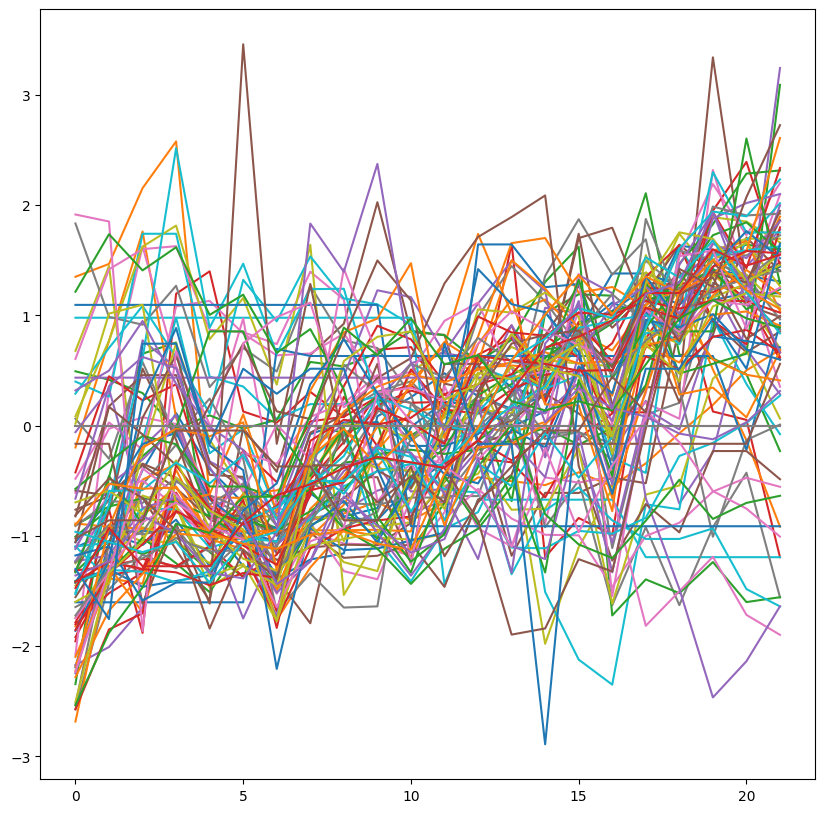

In [25]:
plt.figure(figsize=(10, 10))
plt.plot(tickers_scaled.T);

# Basic KMeans

  0%|          | 0/8 [00:00<?, ?it/s]

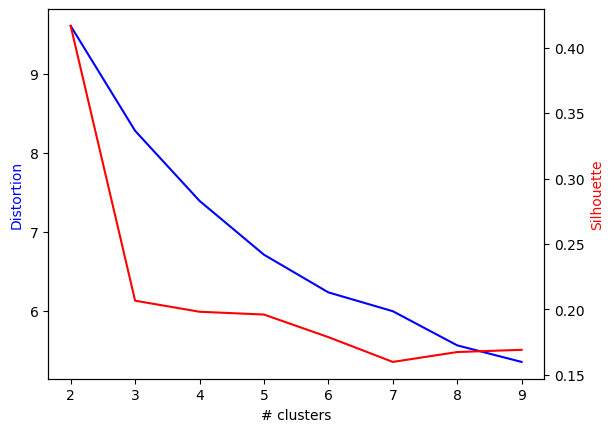

In [26]:
distortions = []
silhouette = []
K = range(2, 10)
for k in tqdm(K):
    kmeanModel = TimeSeriesKMeans(n_clusters=k, metric="euclidean", n_jobs=6, max_iter=10, n_init=5)
    kmeanModel.fit(tickers_scaled)
    distortions.append(kmeanModel.inertia_)
    silhouette.append(silhouette_score(tickers_scaled, kmeanModel.labels_, metric="euclidean"))
    # silhouette_score считает насколько чисты класстеры

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(K, distortions, 'b-')
ax2.plot(K, silhouette, 'r-')

ax1.set_xlabel('# clusters')
ax1.set_ylabel('Distortion', color='b')
ax2.set_ylabel('Silhouette', color='r')

plt.show()

In [29]:
n_clusters = 3
ts_kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", n_jobs=6, max_iter=10)
ts_kmeans.fit(tickers_scaled)

TimeSeriesKMeans(max_iter=10, n_jobs=6)

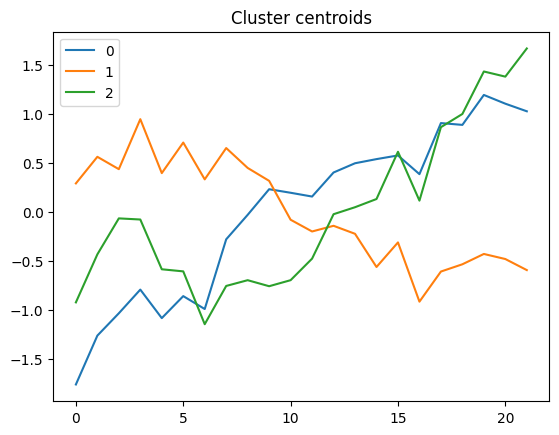

In [30]:
for cluster_number in range(n_clusters): # Построим усредненные ряды внутри каждого кластера
    plt.plot(ts_kmeans.cluster_centers_[cluster_number, :, 0].T, label=cluster_number)
plt.title("Cluster centroids") # Быки и медведи
plt.legend()
plt.show()

In [31]:
full_ticker_df['cluster'] = ts_kmeans.predict(tickers_scaled)
pd.DataFrame(full_ticker_df.groupby('cluster')['sector'].value_counts())

sector
cluster sector                        
0       Technology                  14
        Energy                       6
        Healthcare                   6
        Financial Services           4
        Consumer Cyclical            3
        Industrials                  3
        Consumer Defensive           2
        Basic Materials              1
        Real Estate                  1
        Utilities                    1
1       Healthcare                   7
        Communication Services       3
        Industrials                  2
        Real Estate                  2
        Consumer Cyclical            1
        Consumer Defensive           1
        Energy                       1
        Financial Services           1
        Technology                   1
2       Healthcare                   7
        Consumer Cyclical            6
        Financial Services           6
        Industrials                  4
        Communication Services       3
        Consumer Defensive           3
        Technology                   3
        Real Estate                  2
        Basic Materials              1
        Energy                       1

In [32]:
def plot_cluster_tickers(current_cluster):
    fig, ax = plt.subplots(
        int(np.ceil(current_cluster.shape[0]/4)),
        4,
        figsize=(15, 3*int(np.ceil(current_cluster.shape[0]/4)))
    )
    fig.autofmt_xdate(rotation=45)
    ax = ax.reshape(-1)

    for index, (_, row) in enumerate(current_cluster.iterrows()):
        ax[index].plot(row.iloc[5:-1])
        ax[index].set_title(f"{row.shortName}\n{row.sector}")
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

                          Cluster number: 0


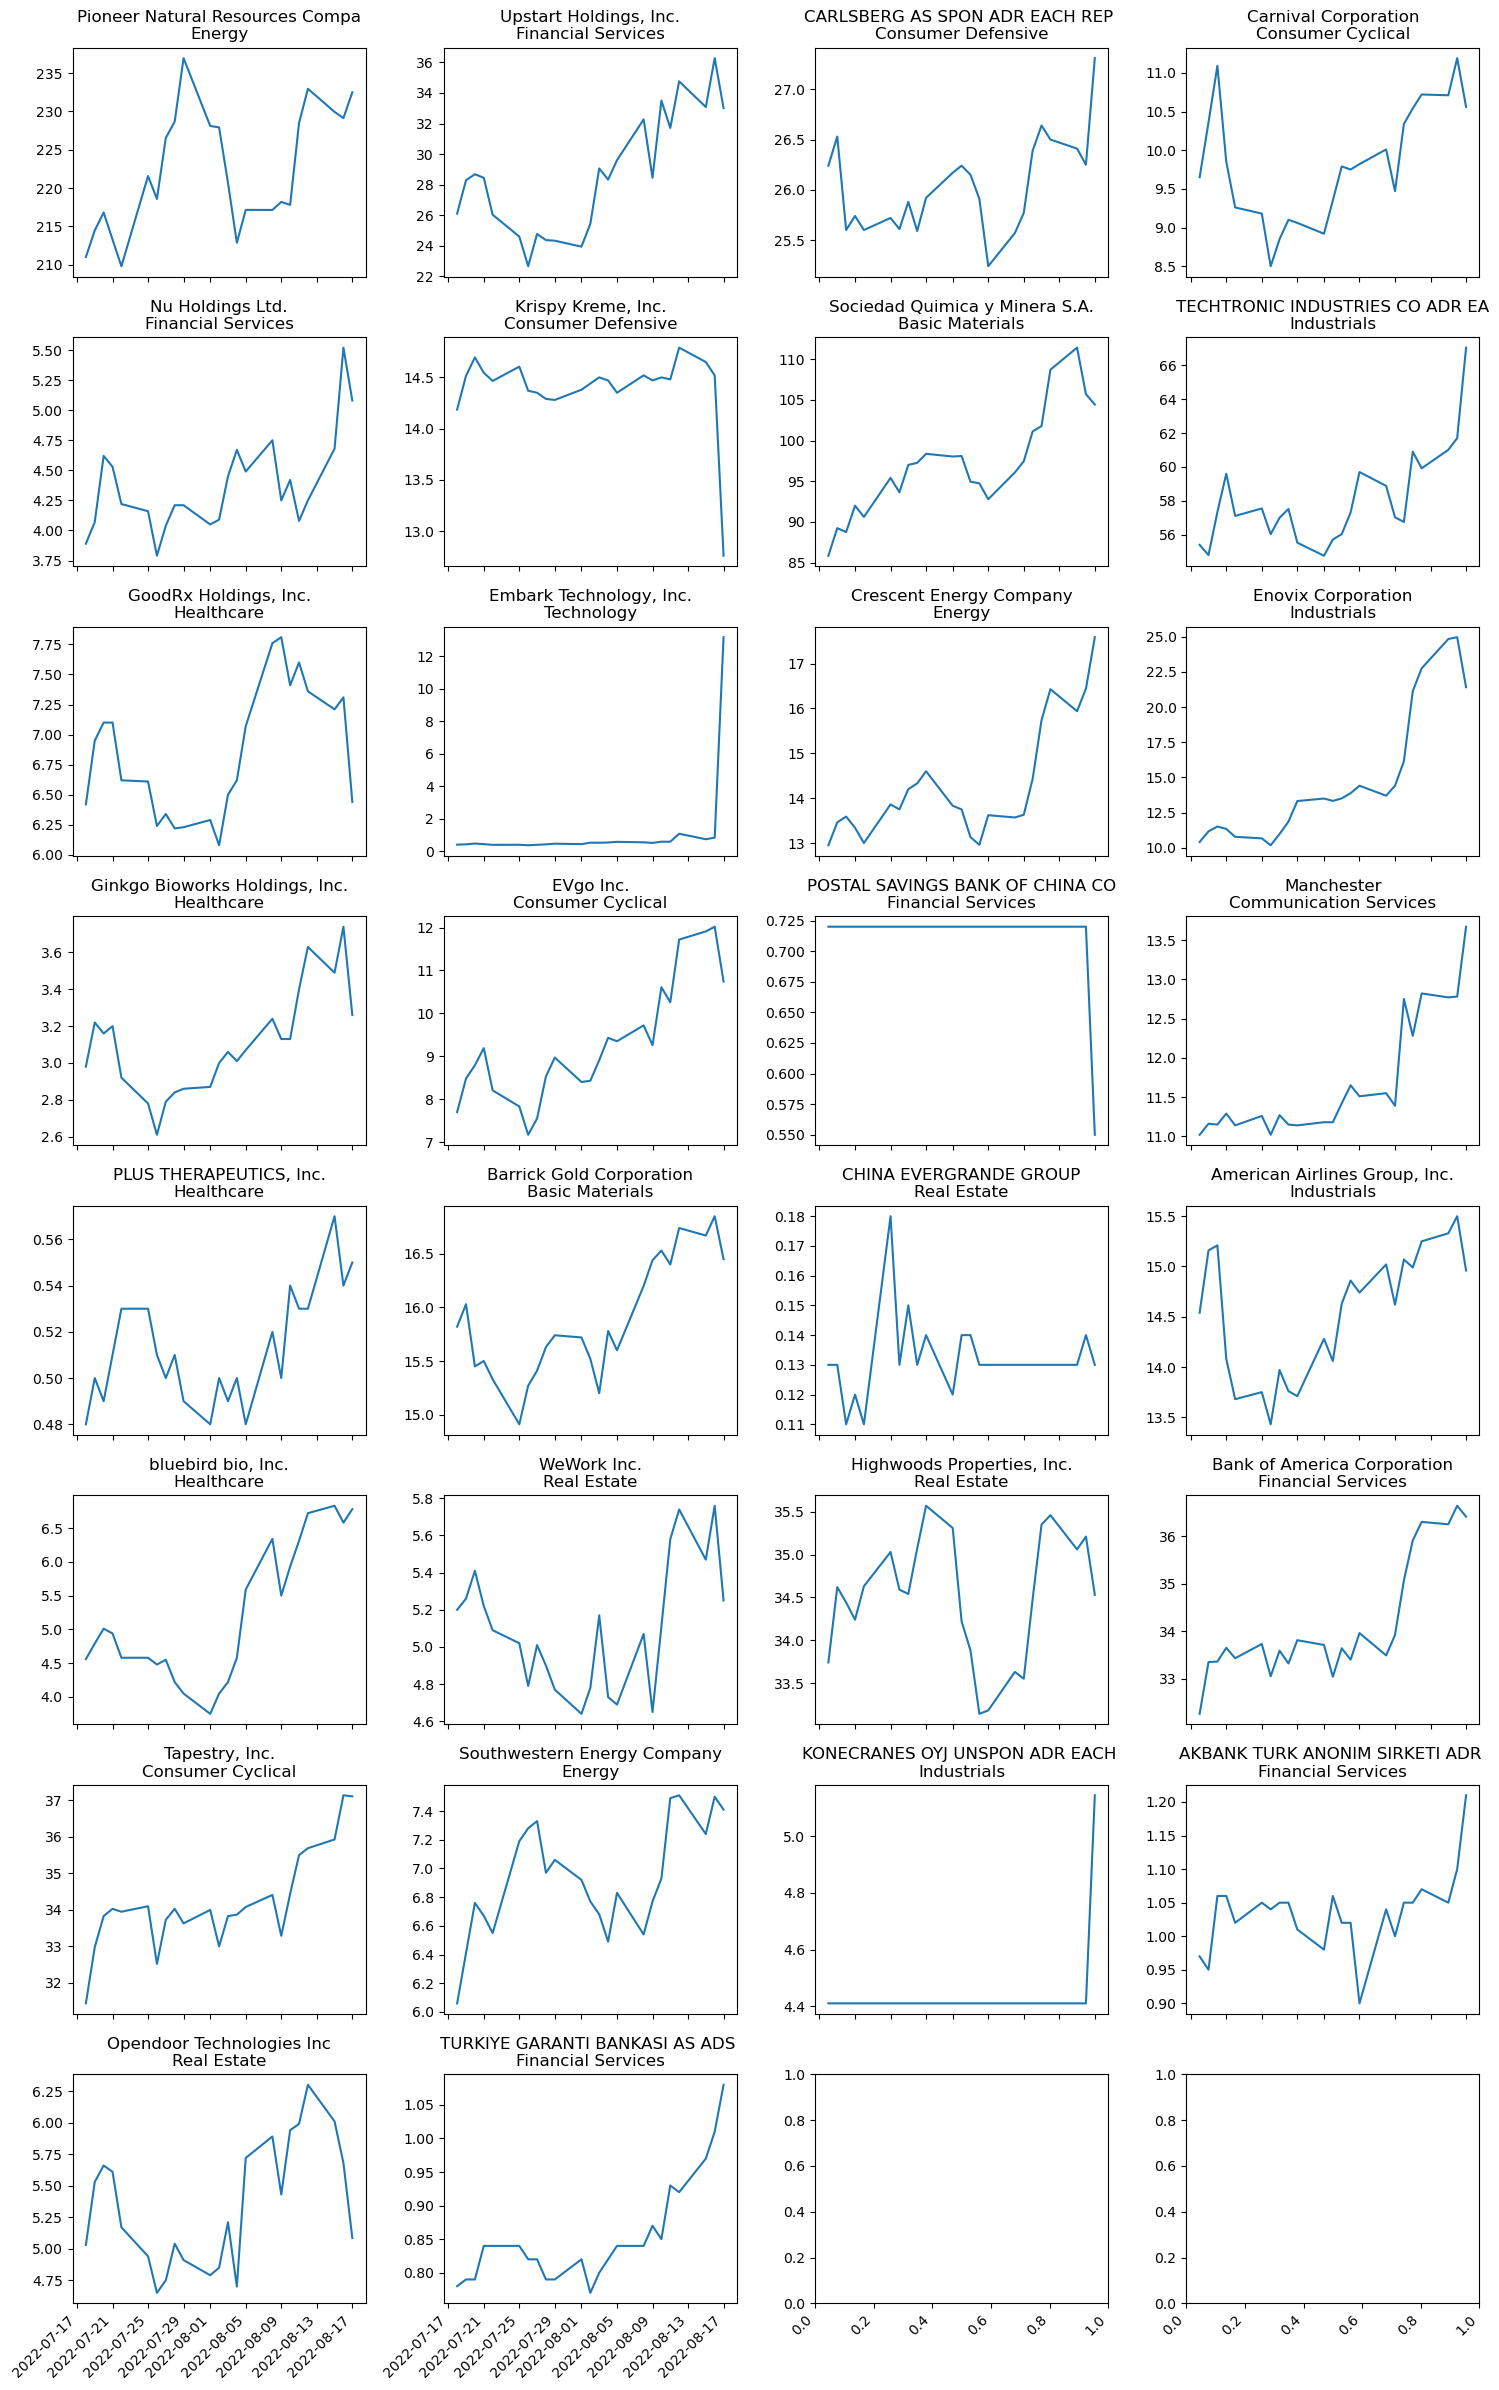

                          Cluster number: 1


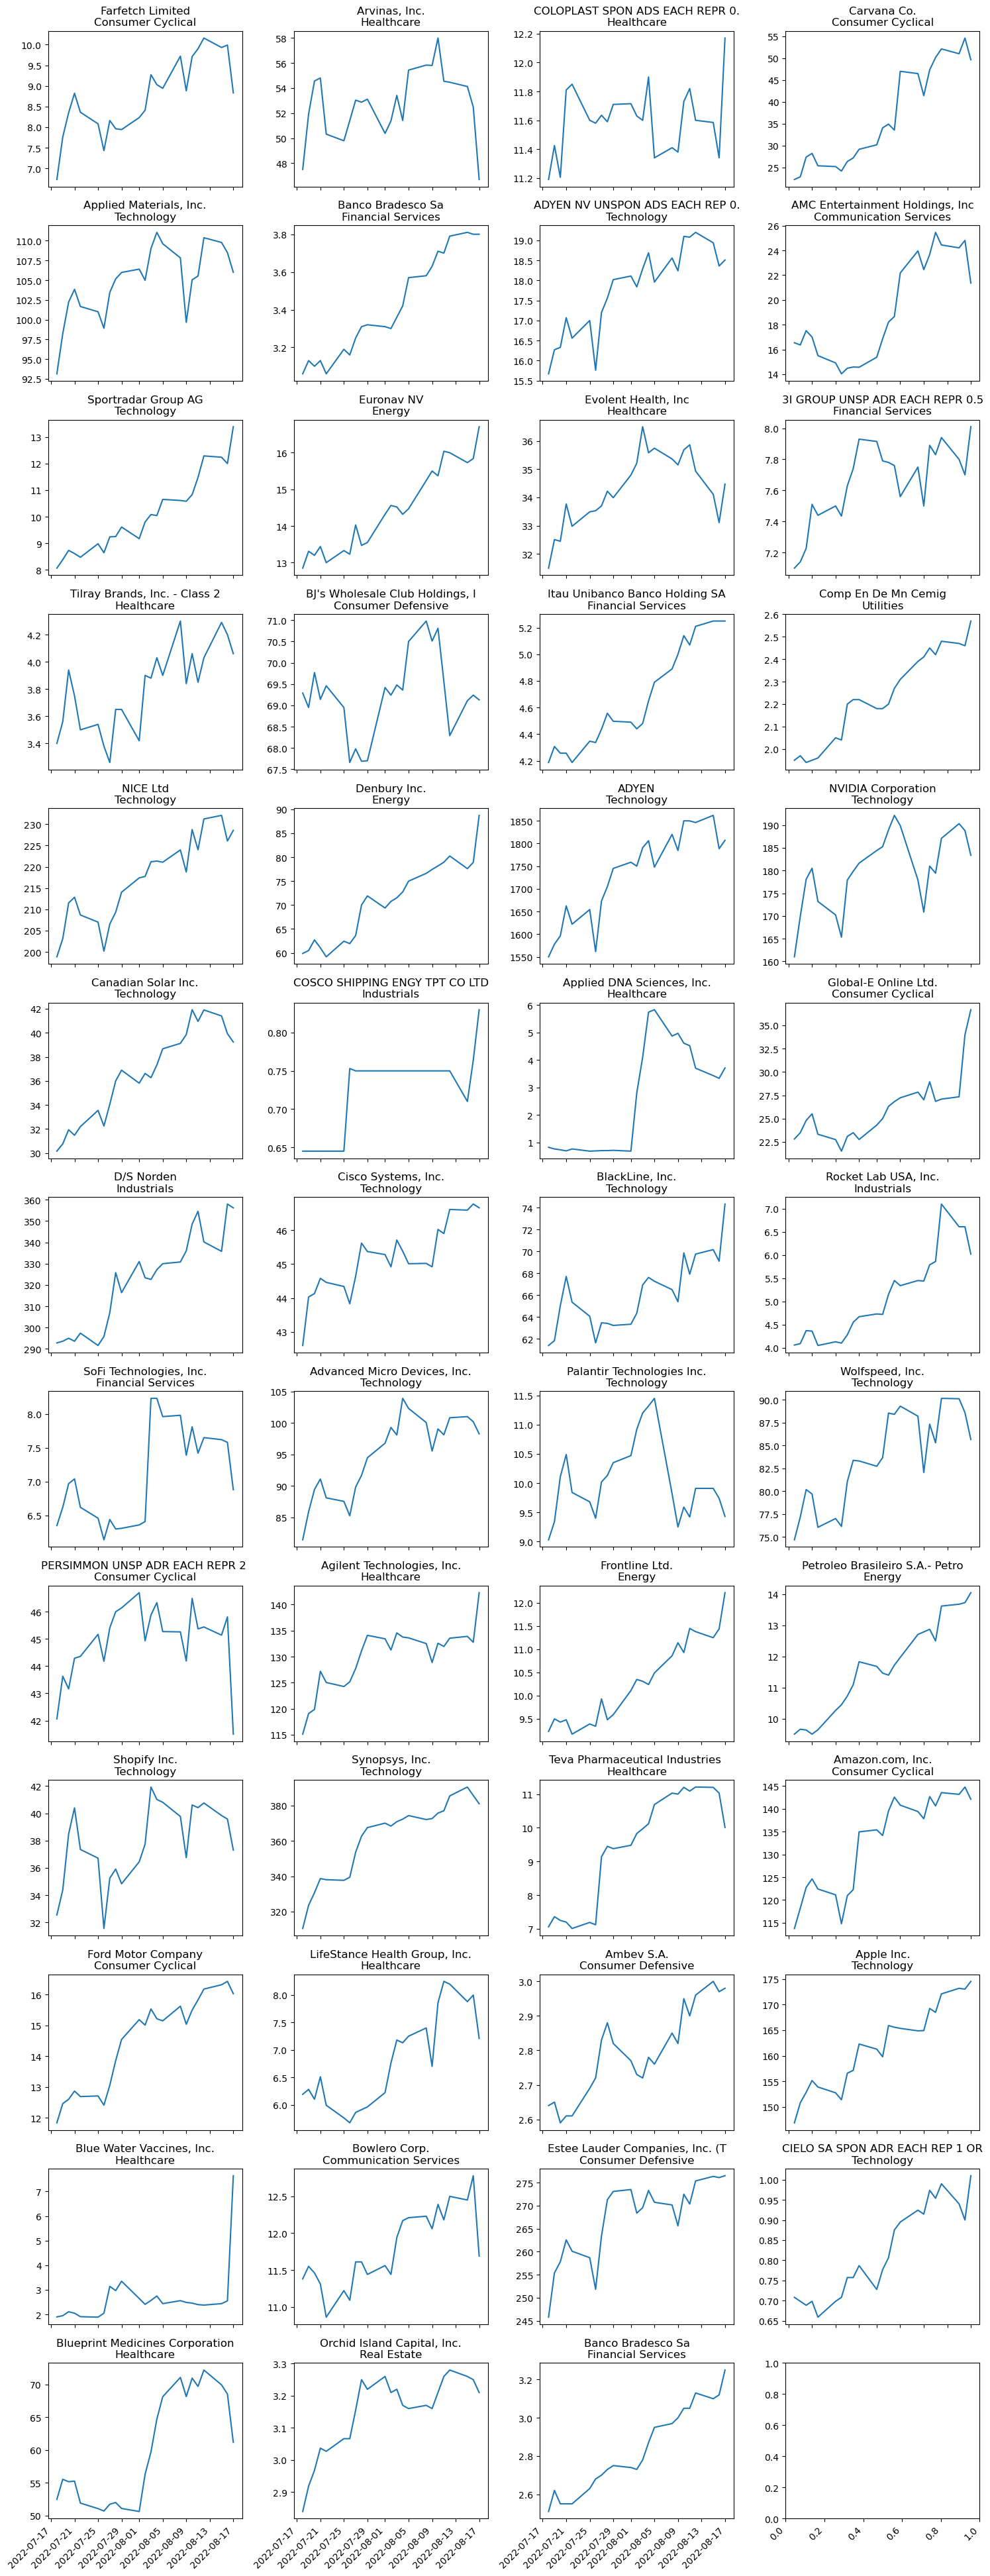

                          Cluster number: 2


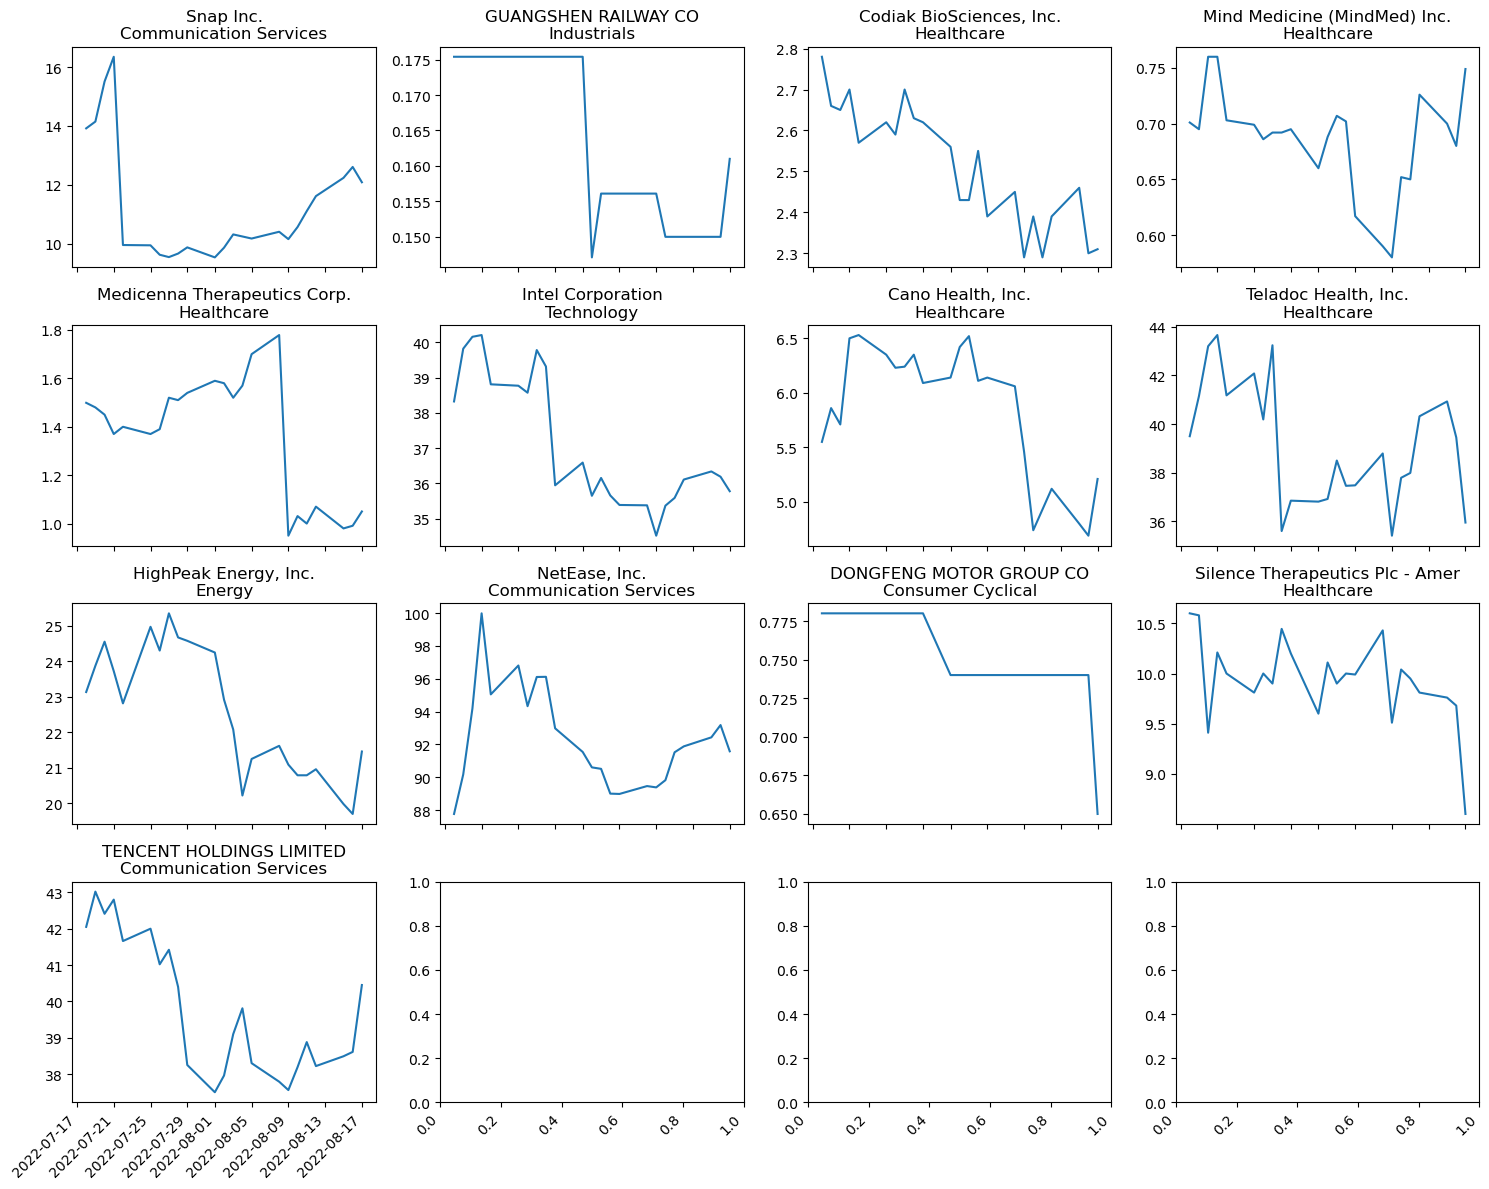

In [ ]:
# TimeSeriesKMeans
for cluster in range(n_clusters):
    print("=================================================================================")
    print(f"                          Cluster number: {cluster}")
    print("=================================================================================")
    plot_cluster_tickers(full_ticker_df[full_ticker_df.cluster==cluster])

# DTW

  0%|          | 0/8 [00:00<?, ?it/s]

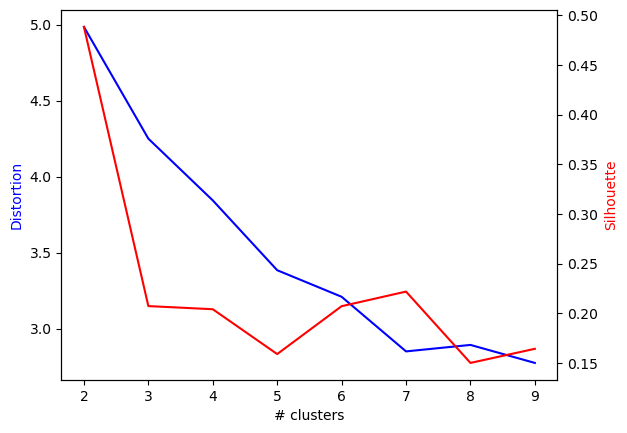

In [ ]:
distortions = []
silhouette = []
K = range(2, 10)
for k in tqdm(K):
    kmeanModel = TimeSeriesKMeans(n_clusters=k, metric="dtw", n_jobs=6, max_iter=10, n_init=5)
    kmeanModel.fit(tickers_scaled)
    distortions.append(kmeanModel.inertia_)
    silhouette.append(silhouette_score(tickers_scaled, kmeanModel.labels_, metric="dtw"))

    # silhouette_score считает насколько чисты класстеры
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html


fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(K, distortions, 'b-')
ax2.plot(K, silhouette, 'r-')

ax1.set_xlabel('# clusters')
ax1.set_ylabel('Distortion', color='b')
ax2.set_ylabel('Silhouette', color='r')

plt.show()

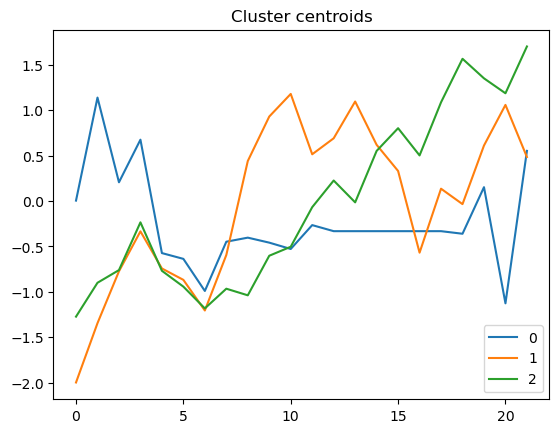

In [ ]:
n_clusters = 3
ts_kmeans_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", n_jobs=6, max_iter=10,random_state=42)
ts_kmeans_dtw.fit(tickers_scaled)

for cluster_number in range(n_clusters):
    plt.plot(ts_kmeans_dtw.cluster_centers_[cluster_number, :, 0].T, label=cluster_number)
plt.title("Cluster centroids")
plt.legend()
plt.show()

In [ ]:
full_ticker_df['cluster'].value_counts()

1    51
0    30
2    13
Name: cluster, dtype: int64

In [ ]:
full_ticker_df['cluster'] = ts_kmeans_dtw.predict(tickers_scaled)
pd.DataFrame(full_ticker_df.groupby('cluster')['sector'].value_counts())

sector
cluster sector                        
0       Healthcare                   6
        Real Estate                  4
        Consumer Defensive           3
        Industrials                  3
        Communication Services       2
        Consumer Cyclical            2
        Financial Services           2
        Energy                       1
        Technology                   1
1       Technology                   7
        Healthcare                   5
        Energy                       2
        Financial Services           2
        Communication Services       1
        Consumer Cyclical            1
        Consumer Defensive           1
        Industrials                  1
        Real Estate                  1
2       Technology                  10
        Healthcare                   9
        Consumer Cyclical            7
        Financial Services           7
        Energy                       5
        Industrials                  4
        Communication Services       3
        Basic Materials              2
        Consumer Defensive           1
        Utilities                    1

                          Cluster number: 0


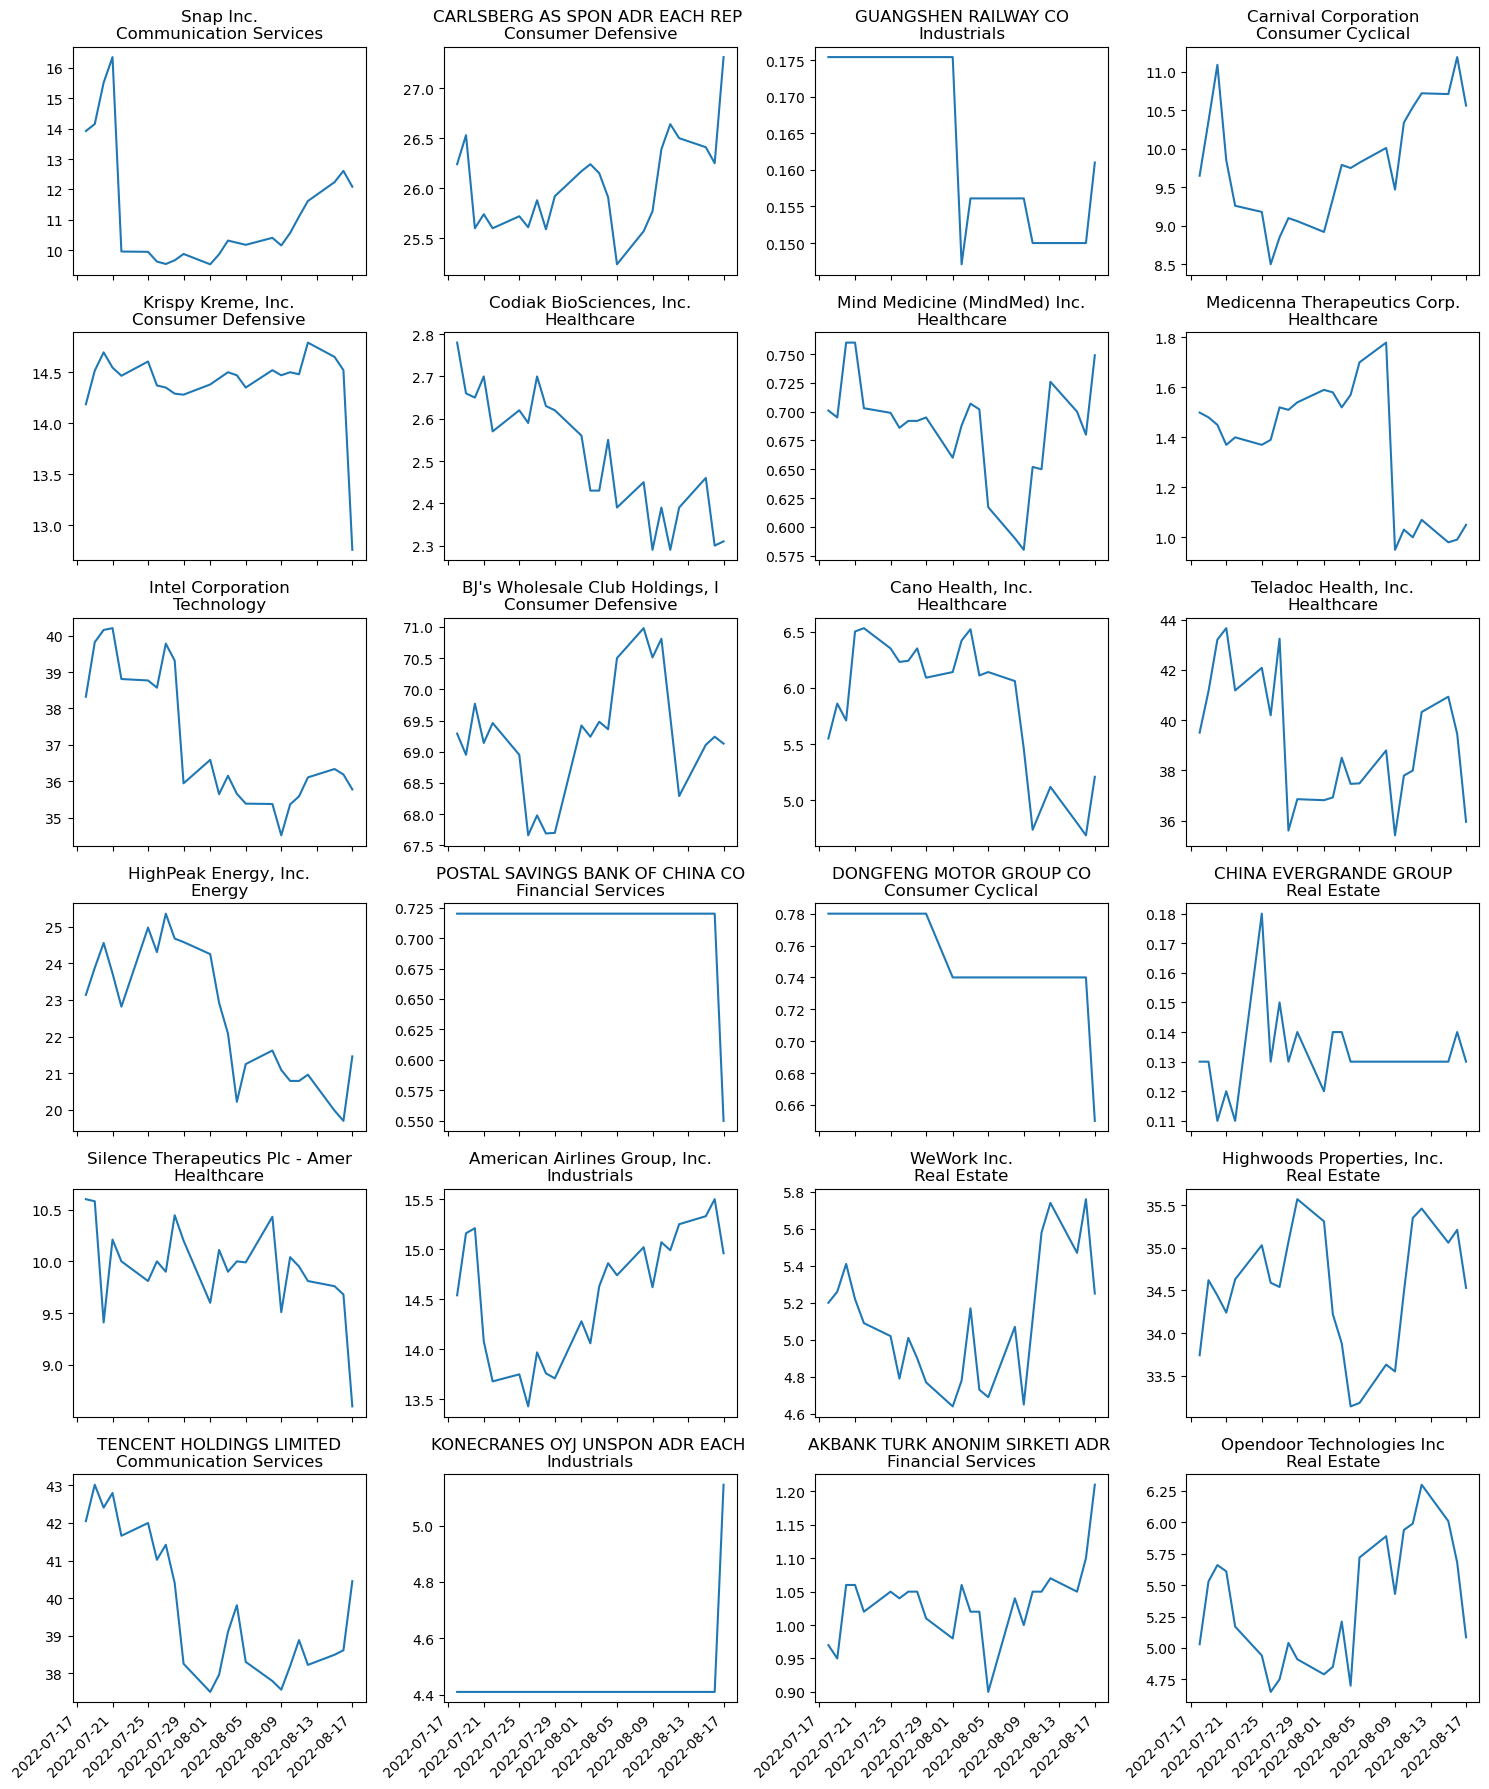

                          Cluster number: 1


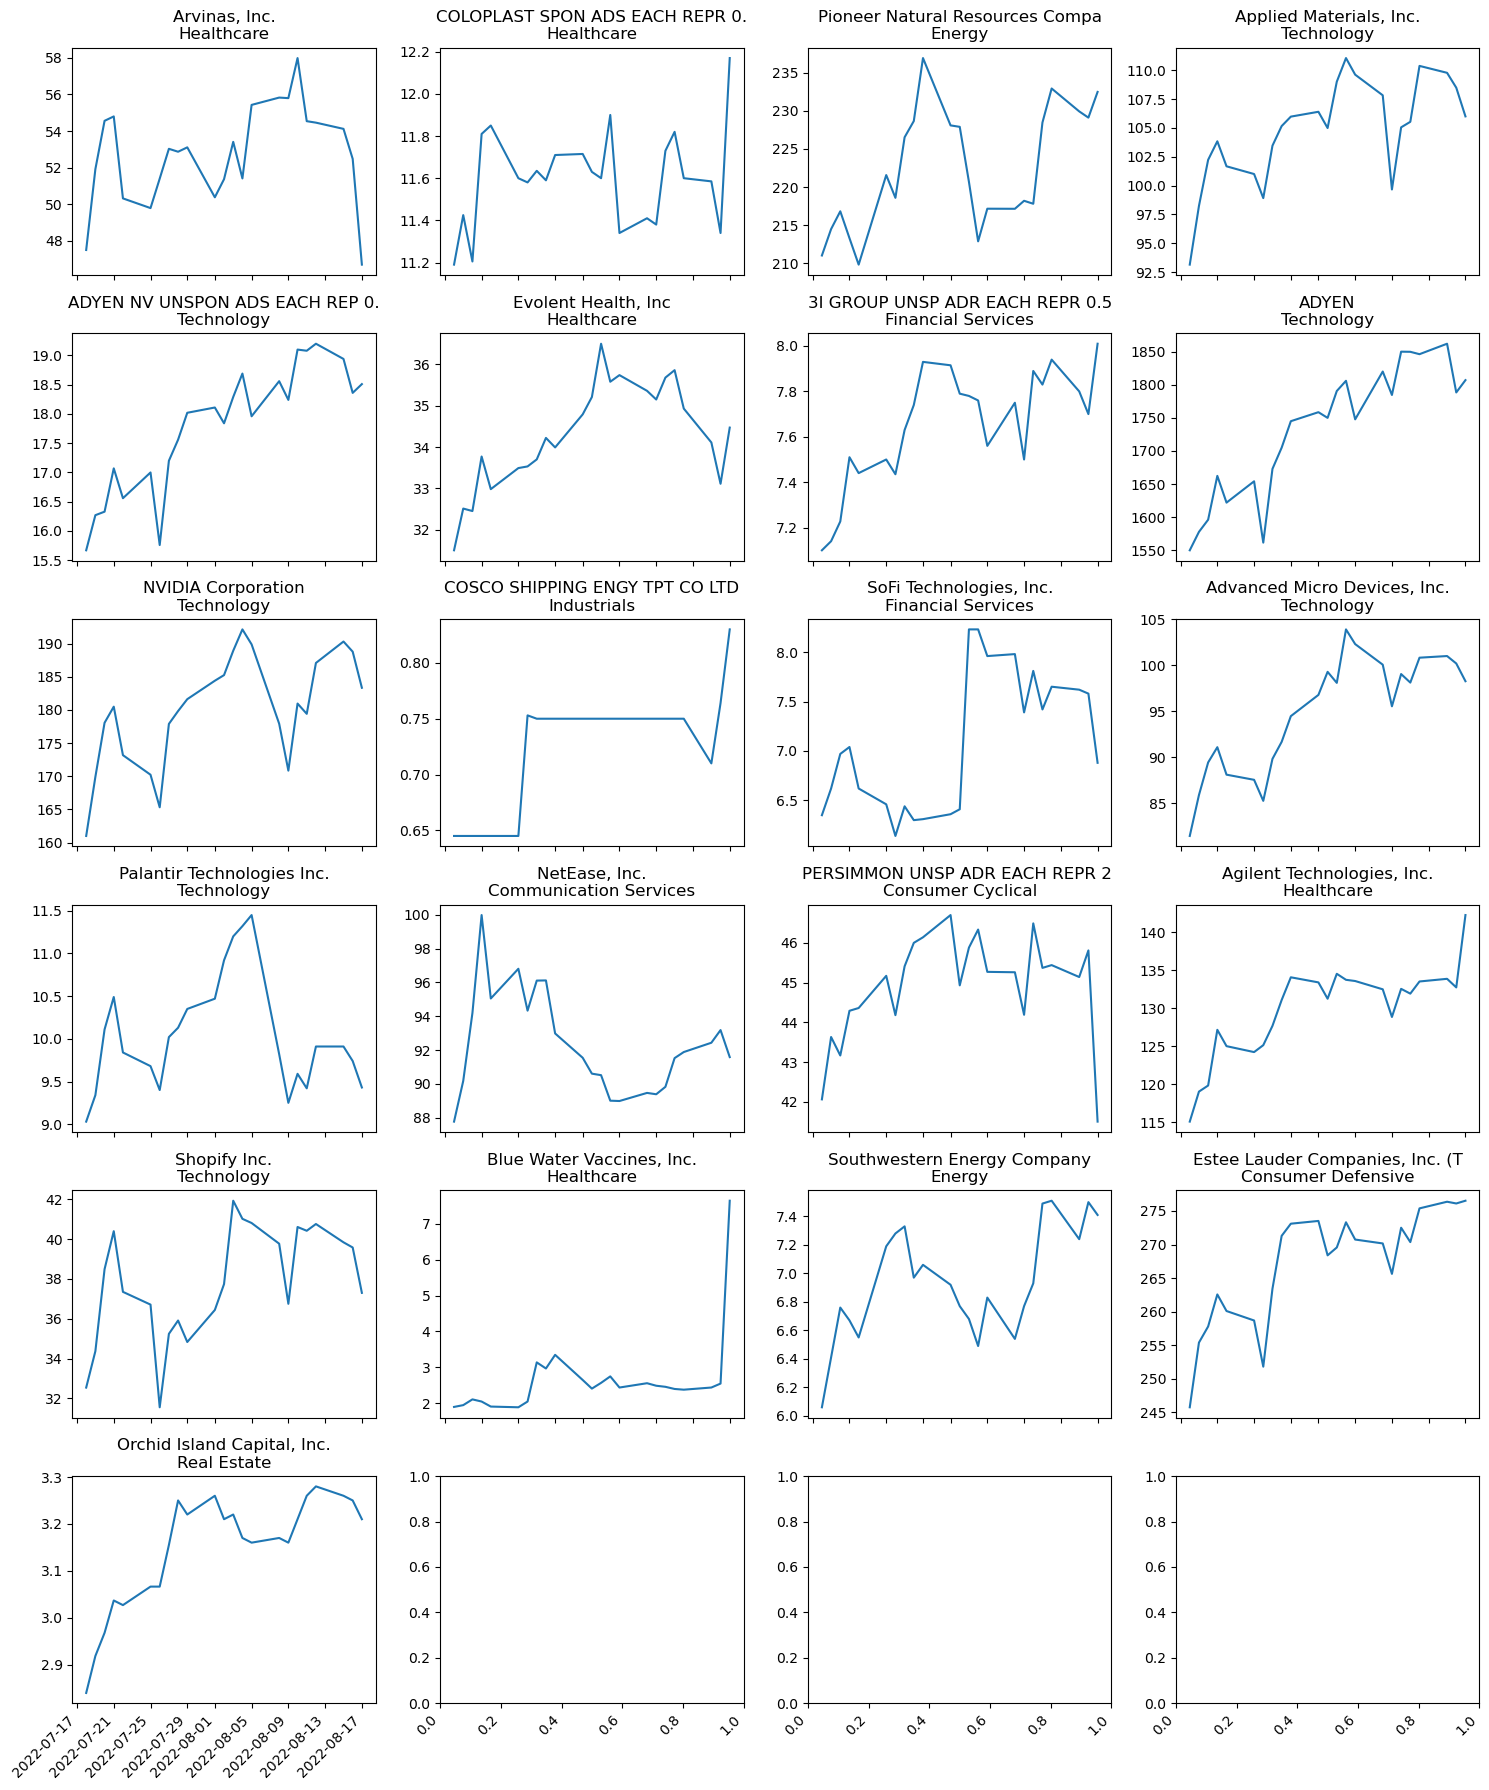

                          Cluster number: 2


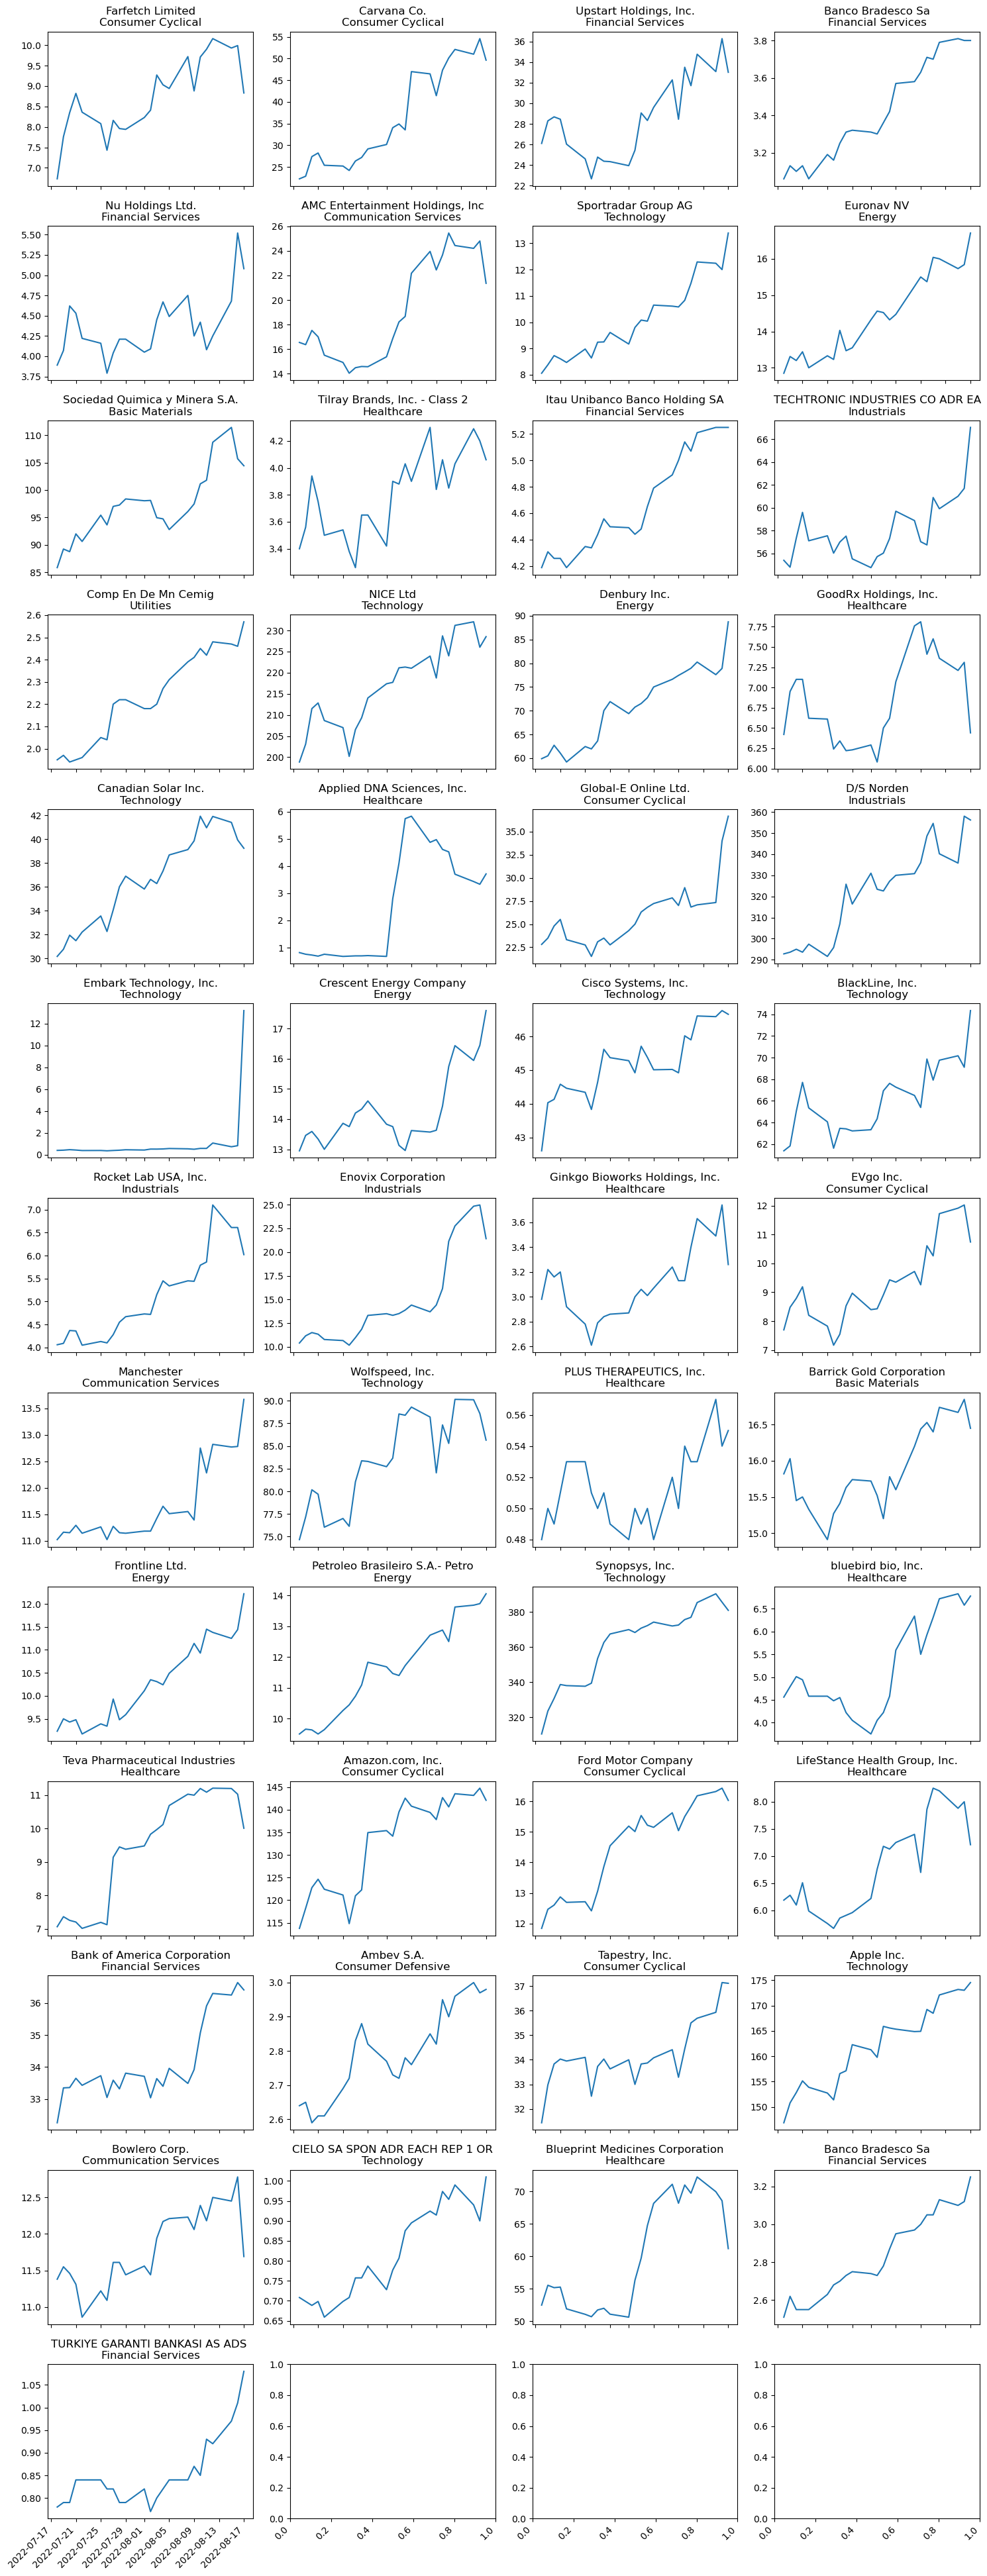

In [ ]:
for cluster in range(n_clusters):
    print("=================================================================================")
    print(f"                          Cluster number: {cluster}")
    print("=================================================================================")
    plot_cluster_tickers(full_ticker_df[full_ticker_df.cluster==cluster])